In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Trained model on demo Image

In [21]:
# this is the github demo image 
bark_img = "bark.jpg"
bark = plt.imread(bark_img)

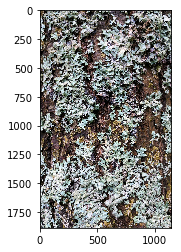

In [22]:
plt.imshow(bark)

In [27]:
demo_output_dir_1 = "outputs/out.L2,7.o4.512x512"
suffix = "_F0000.png" 

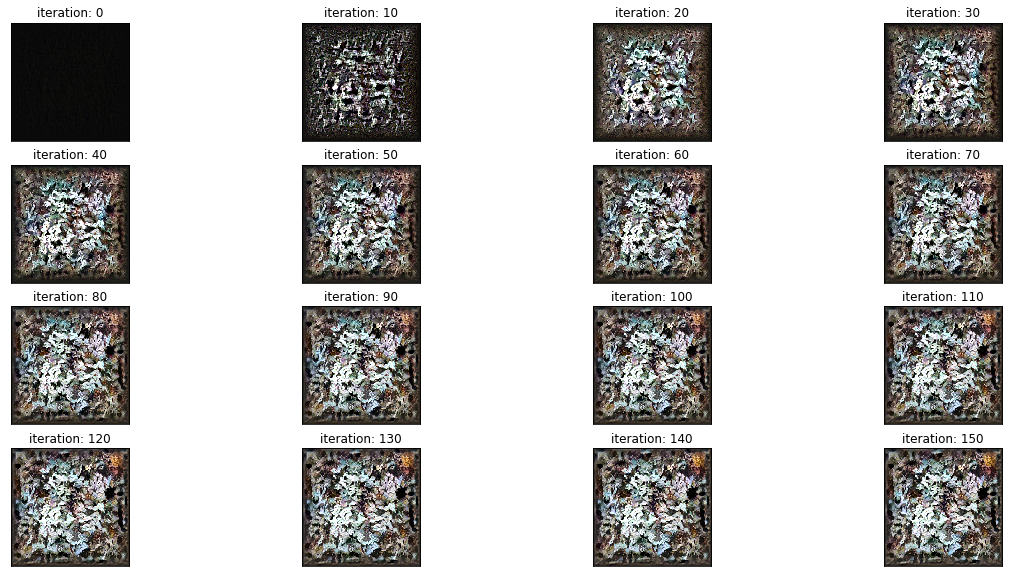

In [54]:
import os
fig = plt.figure(figsize = (20, 10))
for i in range(16):
    idx = '{:04d}'.format(i * 10)
    img = os.path.join(demo_output_dir_1, 'I{}{}'.format(idx, suffix))
    #print(img)
    img = plt.imread(img)
    fig.add_subplot(4, 4, i + 1, yticks=[], xticks=[], title = "iteration: {}".format(str(i * 10)))
    plt.imshow(img)
plt.show()

### Trained model on our images
- takes ~25 mins for ~170 iterations
- terminate the training by hand at iteration 170

In [15]:
# Nature example
example = "sun_dzqczkfbtaeaezqu.jpg"

In [19]:
example_img = plt.imread(example)

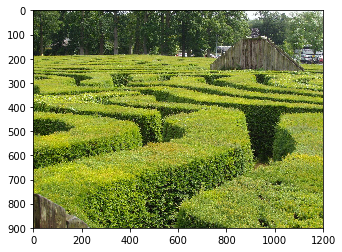

In [20]:
plt.imshow(example_img)

In [55]:
MIT_output_dir = "MIT_example/out.L2,7.o4.512x512"
suffix = "_F0000.png" 

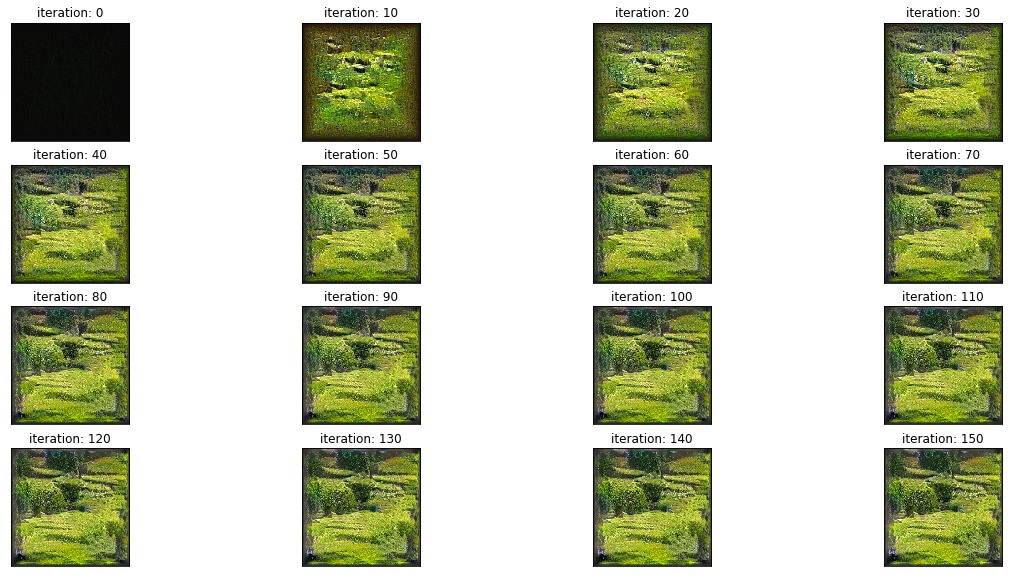

In [56]:
# visualize first 150 iterations
import os
fig = plt.figure(figsize = (20, 10))
for i in range(16):
    idx = '{:04d}'.format(i * 10)
    img = os.path.join(MIT_output_dir, 'I{}{}'.format(idx, suffix))
    #print(img)
    img = plt.imread(img)
    fig.add_subplot(4, 4, i + 1, yticks=[], xticks=[], title = "iteration: {}".format(str(i * 10)))
    plt.imshow(img)
plt.show()

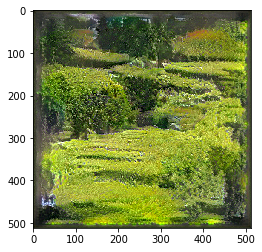

In [60]:
# cut down the algorithm at iteration 170
final = os.path.join(MIT_output_dir, "I0170_F0000.png")
final_img = plt.imread(final)
plt.imshow(final_img)

In [61]:
# Urban Example
urban_example = "16153261485_4146b8bc89_k.jpg"

In [62]:
urban_img = plt.imread(urban_example)

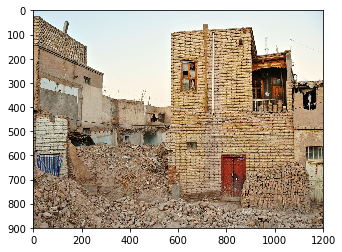

In [63]:
plt.imshow(urban_img)

In [64]:
MIT_output_dir_urban = "MIT_example_urban/out.L2,7.o4.512x512"
suffix = "_F0000.png" 

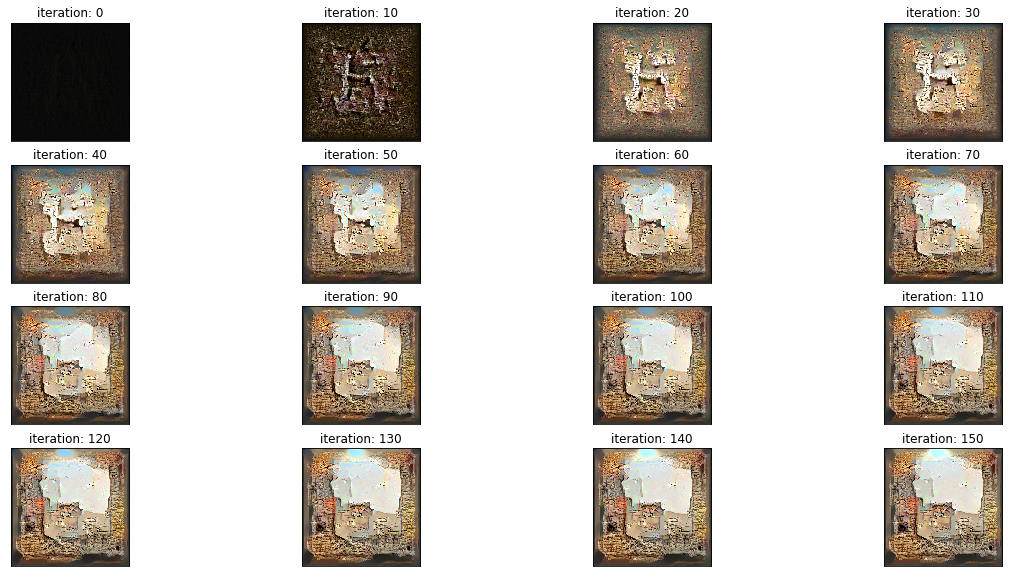

In [65]:
# visualize first 150 iterations
import os
fig = plt.figure(figsize = (20, 10))
for i in range(16):
    idx = '{:04d}'.format(i * 10)
    img = os.path.join(MIT_output_dir_urban, 'I{}{}'.format(idx, suffix))
    #print(img)
    img = plt.imread(img)
    fig.add_subplot(4, 4, i + 1, yticks=[], xticks=[], title = "iteration: {}".format(str(i * 10)))
    plt.imshow(img)
plt.show()

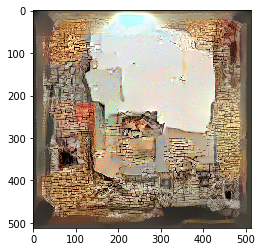

In [66]:
# cut down the algorithm at iteration 170
final = os.path.join(MIT_output_dir_urban, "I0170_F0000.png")
final_img = plt.imread(final)
plt.imshow(final_img)

### Algorithm
#### Motivation: Synthesize textures for high-resolution images
#### Intuition: Gram Matrix + Gaussian Pyramid
   - Gram Matrix: evaluate whether two different features (on a certain layer of the neural network) are activate in some similiar regions ~ evaluate the correlation between features
   - Goal is to minimize the difference between the Gram matrix of the source image and that of the synthesized image. 
   - Gaussian Pyramid: sample the image at different scale 
   - the Gram Matrix method was proposed by Gatys, and it faced the problem that, compared to a high-resolution image, the receptive fields of a CNN are small; thus the model can only synthesize textures that are "semantically significant" at a certain scale. The author of this paper introduced Gaussian Pyramid to leverages the Gram Matrix method at different scale. 
   
#### Algorithm at high level:
1. take a source image
2. randomly initialize a synthezied image
3. while not converge:
    - feed both the source image and the synthesized image into a CNN
    - extract their feature maps at each level and compute their Gram Matrices, respectively
    - compute the Frobenius distance between the Gram Matrices for the source image and those for the synthesized image; this distance is the loss we want to minimize
4. gradient descent to minimize this loss

#### Some rough thoughts about next step:
- we can look into the Gram matrices (of the source images) and see if feature correlations are significantly different for nature & urban scenes
- the current model are using feature maps from all levels; if we are only interested in higher-level features, I wonder if we can try using only receptive fields at higher levels and see if it can still achieve a reasonable result. 
- can we feed the synthesized image into a trained urban/nature scene classifer and see how well the classifer does compared to its performance on "real" urban/nature images?
- It seems to me that the synthesized images capture the "essence" of the textures, but their simulation of the positional relations among these textures are relatively rough. It makes sense because the gram matrix kind of aggregate the spatial information. And I feel it might be interesting to have people rating these synthesized images in terms of nature v.s. urban as well, so that we know how important a role textures plays when we identify urban v.s. nature scenes. 

### DeepTexture

In [3]:
%load_ext autoreload
%autoreload 2
import glob
import sys
import os
from collections import OrderedDict
import caffe
from DeepImageSynthesis import *

In [2]:
# set path
base_dir = os.getcwd()
sys.path.append(base_dir)
im_dir = os.path.join(base_dir, 'Images/')

In [3]:
# load model
VGGweights = os.path.join(base_dir, 'Models/vgg_normalised.caffemodel')
VGGmodel = os.path.join(base_dir, 'Models/VGG_ave_pool_deploy.prototxt')

In [4]:
import numpy as np
imagenet_mean = np.array([ 0.40760392,  0.45795686,  0.48501961])
# use the computed mean
image_mean = np.array([0.4775267, 0.49077275, 0.463214])

In [5]:
# set gpu
gpu = 0
caffe.set_mode_gpu()
caffe.set_device(gpu)

/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


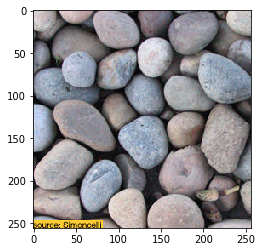

In [6]:
#load source image
source_img_name = glob.glob1(im_dir, 'pebbles.jpg')[0]
source_img_org = caffe.io.load_image(im_dir + source_img_name)
im_size = 256.
[source_img, net] = load_image(im_dir + source_img_name, im_size, 
                            VGGmodel, VGGweights, imagenet_mean, 
                            show_img=True)
im_size = np.asarray(source_img.shape[-2:])

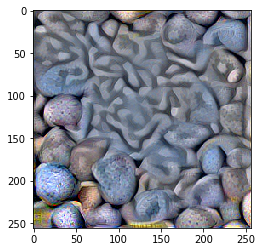

In [ ]:
#l-bfgs parameters optimisation
# I terminated this training early; otherwise it gives a very nice reconstruction
maxiter = 2000
m = 20

#define layers to include in the texture model and weights w_l
tex_layers = ['pool4', 'pool3', 'pool2', 'pool1', 'conv1_1']
tex_weights = [1e9,1e9,1e9,1e9,1e9]

#pass image through the network and save the constraints on each layer
constraints = OrderedDict()
net.forward(data = source_img)
for l,layer in enumerate(tex_layers):
    constraints[layer] = constraint([LossFunctions.gram_mse_loss],
                                    [{'target_gram_matrix': gram_matrix(net.blobs[layer].data),
                                     'weight': tex_weights[l]}])
    
#get optimisation bounds
bounds = get_bounds([source_img],im_size)

#generate new texture
result = ImageSyn(net, constraints, bounds=bounds,
                  callback=lambda x: show_progress(x,net), 
                  minimize_options={'maxiter': maxiter,
                                    'maxcor': m,
                                    'ftol': 0, 'gtol': 0})

### Train on places patches

In [28]:
# set path
base_dir = os.getcwd()
sys.path.append(base_dir)
im_dir = "/home/canliu/ENL_NetDissect/patches_VAE/MIT_ImageRatings/All_other_MIT_images/"
cropped_dir = "/home/canliu/ENL_NetDissect/patches_VAE/MIT_ImageRatings/cropped_images/"

In [5]:
# load model
VGGweights = os.path.join(base_dir, 'Models/vgg_normalised.caffemodel')
VGGmodel = os.path.join(base_dir, 'Models/VGG_ave_pool_deploy.prototxt')

In [6]:
import numpy as np
imagenet_mean = np.array([ 0.40760392,  0.45795686,  0.48501961])

# mean computed from patches
image_mean = np.array([0.4775267, 0.49077275, 0.463214])

In [7]:
# set gpu
gpu = 0
caffe.set_mode_gpu()
caffe.set_device(gpu)

In [29]:
# train on 256 x 256 patches ~ 100 iterations / 1 min 50 secs (should be faster)
source_img_name = "10030281684_9debe5f38e_k.jpg"
cropped_img_name = source_img_name.split(".")[0] + "_cropped" + ".jpg"
source_img_org = caffe.io.load_image(im_dir + source_img_name)
source_img_cropped = source_img_org[:256, :256]  # get a 256 x 256 patch
plt.imsave(cropped_dir + cropped_img_name, source_img_cropped)
im_size = 256.

/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


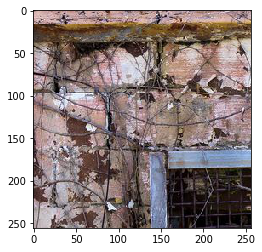

In [30]:
[source_img, net] = load_image(cropped_dir + cropped_img_name, im_size, 
                            VGGmodel, VGGweights, imagenet_mean, 
                            show_img=True)

In [33]:
im_size = np.asarray(source_img.shape[-2:])
print("image size: {}".format(im_size))

image size: [256 256]


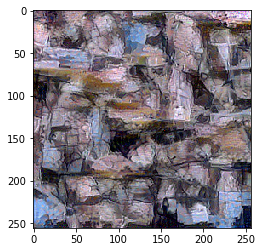

In [37]:
#l-bfgs parameters optimisation
# run for ~ 2 mins (should be faster if not showing the images)
maxiter = 100
m = 20

#define layers to include in the texture model and weights w_l
tex_layers = ['pool4', 'pool3', 'pool2', 'pool1', 'conv1_1']
tex_weights = [1e9,1e9,1e9,1e9,1e9]

#pass image through the network and save the constraints on each layer
constraints = OrderedDict()
net.forward(data = source_img)
for l,layer in enumerate(tex_layers):
    constraints[layer] = constraint([LossFunctions.gram_mse_loss],
                                    [{'target_gram_matrix': gram_matrix(net.blobs[layer].data),
                                     'weight': tex_weights[l]}])

#get optimisation bounds
bounds = get_bounds([source_img],im_size)

#generate new texture
result = ImageSyn(net, constraints, bounds=bounds,
                  callback=lambda x: show_progress(x,net), 
                  minimize_options={'maxiter': maxiter,
                                    'maxcor': m,
                                    'ftol': 0, 'gtol': 0})

In [38]:
## try on 128 x 128 pixels ~ 200 iterations / 1 min 50s (should be faster)
source_img_name = "10030281684_9debe5f38e_k.jpg"
cropped_img_name = source_img_name.split(".")[0] + "_cropped_128" + ".jpg"
source_img_org = caffe.io.load_image(im_dir + source_img_name)
source_img_cropped = source_img_org[:128, :128]  # get a 256 x 256 patch
plt.imsave(cropped_dir + cropped_img_name, source_img_cropped)
im_size = 128.

/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


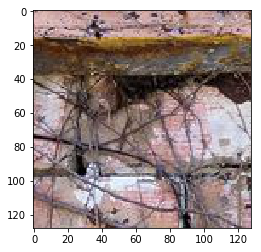

In [39]:
[source_img, net] = load_image(cropped_dir + cropped_img_name, im_size, 
                            VGGmodel, VGGweights, imagenet_mean, 
                            show_img=True)

In [40]:
im_size = np.asarray(source_img.shape[-2:])
print("image size: {}".format(im_size))

image size: [128 128]


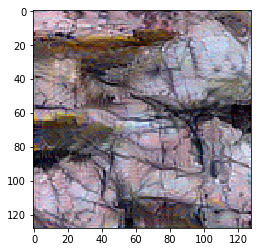

In [42]:
#l-bfgs parameters optimisation
maxiter = 200
m = 20

#define layers to include in the texture model and weights w_l
tex_layers = ['pool4', 'pool3', 'pool2', 'pool1', 'conv1_1']
tex_weights = [1e9,1e9,1e9,1e9,1e9]

#pass image through the network and save the constraints on each layer
constraints_128 = OrderedDict()
net.forward(data = source_img)
for l,layer in enumerate(tex_layers):
    constraints[layer] = constraint_128([LossFunctions.gram_mse_loss],
                                    [{'target_gram_matrix': gram_matrix(net.blobs[layer].data),
                                     'weight': tex_weights[l]}])

#get optimisation bounds
bounds_128 = get_bounds([source_img],im_size) # read this code later

#generate new texture
result = ImageSyn(net, constraints_128, bounds=bounds,
                  callback=lambda x: show_progress(x,net), 
                  minimize_options={'maxiter': maxiter,
                                    'maxcor': m,
                                    'ftol': 0, 'gtol': 0})

In [43]:
# now 64 x 64!
## try on 128 x 128 pixels ~ 100 iterations / min (should be faster)
source_img_name = "10030281684_9debe5f38e_k.jpg"
cropped_img_name = source_img_name.split(".")[0] + "_cropped_64" + ".jpg"
source_img_org = caffe.io.load_image(im_dir + source_img_name)
source_img_cropped = source_img_org[:64, :64]  # get a 64 x 64 patch
plt.imsave(cropped_dir + cropped_img_name, source_img_cropped)
im_size = 64.

/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


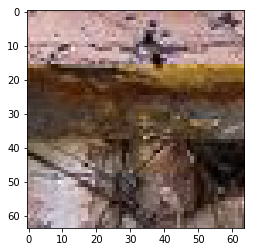

In [44]:
[source_img, net] = load_image(cropped_dir + cropped_img_name, im_size, 
                            VGGmodel, VGGweights, imagenet_mean, 
                            show_img=True)

In [45]:
im_size = np.asarray(source_img.shape[-2:])
print("image size: {}".format(im_size))

image size: [64 64]


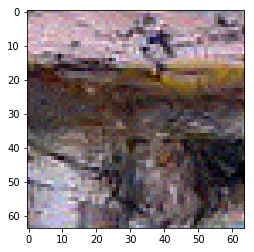

In [46]:
#l-bfgs parameters optimisation
maxiter = 200
m = 20

#define layers to include in the texture model and weights w_l
tex_layers = ['pool4', 'pool3', 'pool2', 'pool1', 'conv1_1']
tex_weights = [1e9,1e9,1e9,1e9,1e9]

#pass image through the network and save the constraints on each layer
constraints = OrderedDict()
net.forward(data = source_img)
for l,layer in enumerate(tex_layers):
    constraints[layer] = constraint([LossFunctions.gram_mse_loss],
                                    [{'target_gram_matrix': gram_matrix(net.blobs[layer].data),
                                     'weight': tex_weights[l]}])

#get optimisation bounds
bounds = get_bounds([source_img],im_size)

#generate new texture
result = ImageSyn(net, constraints, bounds=bounds,
                  callback=lambda x: show_progress(x,net), 
                  minimize_options={'maxiter': maxiter,
                                    'maxcor': m,
                                    'ftol': 0, 'gtol': 0})

### Try reconstruct with different layers

In [112]:
source_img_name = "10030281684_9debe5f38e_k.jpg"
cropped_img_name = source_img_name.split(".")[0] + "_cropped_64" + ".jpg"
source_img_org = caffe.io.load_image(im_dir + source_img_name)
source_img_cropped = source_img_org[:64, :64]  # get a 64 x 64 patch
plt.imsave(cropped_dir + cropped_img_name, source_img_cropped)
im_size = 64.

/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


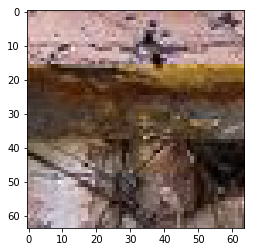

In [113]:
[source_img, net] = load_image(cropped_dir + cropped_img_name, im_size, 
                            VGGmodel, VGGweights, imagenet_mean, 
                            show_img=True)

In [114]:
im_size = np.asarray(source_img.shape[-2:])
print("image size: {}".format(im_size))

image size: [64 64]


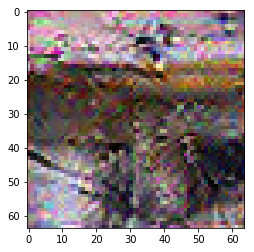

In [117]:
#l-bfgs parameters optimisation
# using top-layer only
maxiter = 1000
m = 20

#define layers to include in the texture model and weights w_l
tex_layers_pool4 = ['pool4']
tex_weights_pool4 = [1e9]

#pass image through the network and save the constraints on each layer
constraints_pool4 = OrderedDict()
net.forward(data = source_img)
for l,layer in enumerate(tex_layers_pool4):
    constraints_pool4[layer] = constraint([LossFunctions.gram_mse_loss],
                                    [{'target_gram_matrix': gram_matrix(net.blobs[layer].data),
                                     'weight': tex_weights_pool4[l]}])

#get optimisation bounds
bounds_pool4 = get_bounds([source_img],im_size)

#generate new texture
result = ImageSyn(net, constraints_pool4, bounds=bounds_pool4,
                  callback=lambda x: show_progress(x,net), 
                  minimize_options={'maxiter': maxiter,
                                    'maxcor': m,
                                    'ftol': 0, 'gtol': 0})

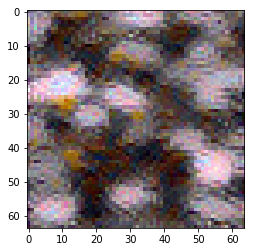

In [118]:
#l-bfgs parameters optimisation
# using bottom-layer only
maxiter = 1000
m = 20

#define layers to include in the texture model and weights w_l
tex_layers_conv1_1 = ['conv1_1']
tex_weights_conv1_1 = [1e9]

#pass image through the network and save the constraints on each layer
constraints_conv1_1 = OrderedDict()
net.forward(data = source_img)
for l,layer in enumerate(tex_layers_conv1_1):
    constraints_conv1_1[layer] = constraint([LossFunctions.gram_mse_loss],
                                    [{'target_gram_matrix': gram_matrix(net.blobs[layer].data),
                                     'weight': tex_weights_conv1_1[l]}])

#get optimisation bounds
bounds_conv1_1 = get_bounds([source_img],im_size)

#generate new texture
result = ImageSyn(net, constraints_conv1_1, bounds=bounds_conv1_1,
                  callback=lambda x: show_progress(x,net), 
                  minimize_options={'maxiter': maxiter,
                                    'maxcor': m,
                                    'ftol': 0, 'gtol': 0})

### Probe the Gram Matrix

In [54]:
model = open(VGGmodel)

In [52]:
constraints

OrderedDict([('pool4', <DeepImageSynthesis.Misc.constraint at 0x7f4cc00b07b8>),
             ('pool3', <DeepImageSynthesis.Misc.constraint at 0x7f4cc00b0048>),
             ('pool2', <DeepImageSynthesis.Misc.constraint at 0x7f4cc00b0160>),
             ('pool1', <DeepImageSynthesis.Misc.constraint at 0x7f4cc00b0e10>),
             ('conv1_1',
              <DeepImageSynthesis.Misc.constraint at 0x7f4cc00b0fd0>)])

In [59]:
conv1_1 = constraints['conv1_1']

In [63]:
conv1_1.loss_functions

[<function DeepImageSynthesis.LossFunctions.gram_mse_loss(activations, target_gram_matrix, weight=1.0, linear_transform=None)>]

In [73]:
conv1_1_parameters = conv1_1.parameter_lists[0]
conv1_1_gram = conv1_1_parameters['target_gram_matrix']
conv1_1_weight = conv1_1_parameters['weight']
conv1_1_activations = conv1_1_parameters['activations']

In [75]:
conv1_1_gram.shape

(64, 64)

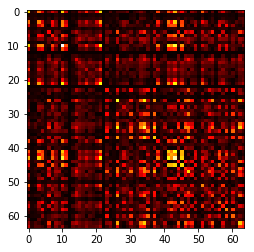

In [78]:
# gram matrix for conv1_1
plt.imshow(conv1_1_gram, cmap="hot")

In [80]:
conv1_1_activations.shape

(1, 64, 64, 64)

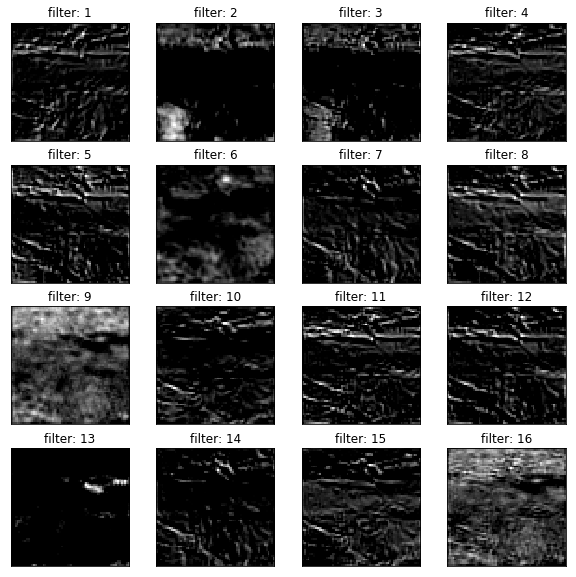

In [94]:
# visualize first 16 activations
activations = conv1_1_activations[0]
fig = plt.figure(figsize = (10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1, yticks=[], xticks=[], title = "filter: {}".format(i + 1))
    plt.imshow(activations[i], cmap="gray")

layer: pool4
shape of gram matrix: (512, 512)
shape of activation: (1, 512, 4, 4)
layer: pool3
shape of gram matrix: (256, 256)
shape of activation: (1, 256, 8, 8)
layer: pool2
shape of gram matrix: (128, 128)
shape of activation: (1, 128, 16, 16)
layer: pool1
shape of gram matrix: (64, 64)
shape of activation: (1, 64, 32, 32)
layer: conv1_1
shape of gram matrix: (64, 64)
shape of activation: (1, 64, 64, 64)


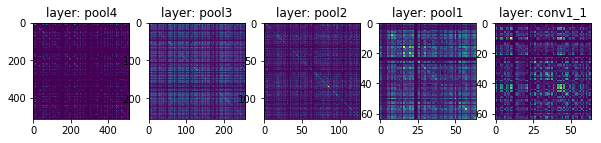

In [103]:
# gram matrix for each pulled out layer
fig = plt.figure(figsize = (10, 10))
for l, layer in enumerate(tex_layers):
    print("layer: {}".format(layer))
    parameters = constraints[layer].parameter_lists[0]
    gram = parameters['target_gram_matrix']
    activation = parameters['activations']
    print("shape of gram matrix: {}".format(gram.shape))
    print("shape of activation: {}".format(activation.shape))
    fig.add_subplot(1, 5, l + 1, title = "layer: {}".format(layer))
    plt.imshow(gram)